#### Team members:
* sshnam2s
* asyed12s
* mliaqu2s
* kbutt2s

# Robot Behaviour Management Using State Machines and Behaviour Trees

In this assignment, we will compare the implementation of behaviour trees and state machines to establish primary safety features for a robot; this includes situations such as the battery level falling below a certain threshold and avoiding potential collisions. In other words, we want to implement both a behaviour tree and a state machine to achieve the same functionality.

We particularly want the robot to behave as follows:
* *The battery level falling below a given threshold*: The robot starts rotating in place until the level is above the threshold again (you can control the battery level by publishing to a topic).
* *A collision is about to happen*: The robot stops moving and needs to be moved to a safe distance manually.

You will use the Robile simulation for testing your implementation. For your submission, you need to add your code to the appropriate cells below; however, note that, to actually test your implementation, you need to integrate the code in a local ROS package and perform all tests on your local machine.

## Robot Safety Functionalities Using a State Machine [45 points]

To implement a state machine, we will use the [SMACH framework](https://wiki.ros.org/smach/Tutorials). SMACH as such is ROS independent, but `executive_smach` provides a ROS integration, which we will be using in this assignment.

Your task here is to implement the necessary states and set up the state machine to achieve the desired robot functionality.

In [1]:
### Implement the safety functionalities for the Robile by setting up
### a state machine and implementing all required states here

import rclpy
import rclpy.parameter
import smach
from rclpy.parameter import Parameter
from rclpy.node import Node
from std_msgs.msg import String
from std_msgs.msg import Float32
from sensor_msgs.msg import LaserScan
from geometry_msgs.msg import Twist
import yaml
import time

# Reference: https://wiki.ros.org/smach/Tutorials/Simple%20State%20Machine [but in ROS1]

class MonitorBatteryAndCollision(smach.State):
    """State to monitor the battery level and possible collisions
    """
    def __init__(self, node):
        # TODO: define outcomes, class variables, and desired publisher/subscribers
        # YOUR CODE HERE
        
        smach.State.__init__(self, outcomes=['low_battery', 'collision', 'safe'], 
                             output_keys=['battery_level', 'collision_detected'], 
                             input_keys=['battery_level', 'collision_detected'])
        
        self.node = node
        self.battery_level = None
        self.collision_detected = False
        self.battery_threshold = 50.0
        self.min_range_value = None
        
        self.collision_sub = self.node.create_subscription(LaserScan, '/scan', self.collision_callback, 10)
        self.battery_pub = self.node.create_publisher(Float32, '/battery_level', 10)
#         self.battery_sub = self.node.create_subscription(Float32, '/battery_level', self.battery_callback, 10)
        self.cmd_pub = self.node.create_publisher(Twist, '/cmd_vel', 10)
        
        # raise NotImplementedError()

#     def battery_callback(self, msg):
#         self.battery_level = msg.data # Getting the battery value of battery from here
    
    def collision_callback(self, msg):
        # Check if any laser scan reading is below a certain threshold, indicating a potential collision
        self.node.get_logger().info('Collision_Callback Received')
        self.min_range_value = min(msg.ranges)
        if min(msg.ranges) < 0.5:
            self.collision_detected = True
        else:
            self.collision_detected = False
    
    def execute(self, userdata):
        # TODO: implement state execution logic and return outcome
        # YOUR CODE HERE
        rclpy.spin_once(self.node, timeout_sec=1.0)
        # Moving the robot forward a bit by bit, so that it collides at some point
        twist = Twist()
        twist.linear.x = 0.5
        self.cmd_pub.publish(twist)

        if self.battery_level is None:
            self.battery_level = 100
            userdata.battery_level = self.battery_level
        else:
            self.battery_level = userdata.battery_level
        
        self.node.get_logger().info('Monitoring battery and collision...')
        self.node.get_logger().info(f'Battery level = {self.battery_level}')
        if self.battery_level > 60.0:
            self.node.get_logger().info('🔋🔋🔋')
        else:
            self.node.get_logger().info('🪫🪫🪫')
        self.node.get_logger().info(f'Min Range Value = {self.min_range_value}')
        self.battery_level -= 0.1  # Decrease battery level
        self.battery_pub.publish(Float32(data=self.battery_level))
        
        userdata.battery_level = self.battery_level
        userdata.collision_detected = self.collision_detected
        
        # Reset the collision_reset parameter to False after a manual reset
        if self.node.get_parameter('collision_reset').get_parameter_value().bool_value:
            self.node.set_parameters([rclpy.parameter.Parameter(name='collision_reset', value=False)])
        
        if self.battery_level < self.battery_threshold:
            return 'low_battery'
        elif self.collision_detected:
            return 'collision'
        else:
            return 'safe'
        
        # raise NotImplementedError()


class RotateBase(smach.State):
    """State to rotate the Robile base
    """
    def __init__(self, node):
        # TODO: define outcomes, class variables, and desired publisher/subscribers
        # YOUR CODE HERE
        
        self.battery_threshold = 99.0
        smach.State.__init__(self, outcomes=['battery_ok'], 
                             output_keys=['battery_level'],
                             input_keys=['battery_level'])
        self.node = node
        self.cmd_pub = self.node.create_publisher(Twist, '/cmd_vel', 10)
        self.battery_pub = self.node.create_publisher(Float32, '/battery_level', 10)
        
        # raise NotImplementedError()

    def execute(self, userdata):
        
        self.node.get_logger().info('Rotating base due to low battery...')
        twist = Twist()
        twist.angular.z = 0.5
        
        while rclpy.ok() and userdata.battery_level < self.battery_threshold:
            userdata.battery_level += 0.1  # Increase battery level
            self.battery_pub.publish(Float32(data=userdata.battery_level))
            self.cmd_pub.publish(twist)
            self.node.get_logger().info(f'Battery level = {userdata.battery_level}')
            self.node.get_logger().info('🪫⚡🔌🔋')
            rclpy.spin_once(self.node, timeout_sec=1.0)
        
        twist.angular.z = 0.0
        self.cmd_pub.publish(twist)
        return 'battery_ok'
        
        # raise NotImplementedError()


class StopMotion(smach.State):
    """State to stop the robot's motion
    """
    def __init__(self, node):
        # TODO: define outcomes, class variables, and desired publisher/subscribers
        # YOUR CODE HERE
        self.battery_threshold = 50.0
        
        smach.State.__init__(self, outcomes=['manual_reset', 'low_battery'], 
                             output_keys=['battery_level'], 
                             input_keys=['collision_detected','battery_level'])
        self.node = node
        self.cmd_pub = self.node.create_publisher(Twist, '/cmd_vel', 10)
        self.battery_pub = self.node.create_publisher(Float32, '/battery_level', 10)
        
        # raise NotImplementedError()

    def execute(self, userdata):
        # TODO: implement state execution logic and return outcome
        # YOUR CODE HERE
        
        self.node.get_logger().info('Stopping motion due to potential collision...')
        twist = Twist()
        self.cmd_pub.publish(twist)
        # Run this command in terminal:( ros2 run teleop_twist_keyboard teleop_twist_keyboard )
        # Move the robot and run this command ( ros2 param set /AST_Assignment collision_reset True )
        # 
        while rclpy.ok() and not self.node.get_parameter('collision_reset').get_parameter_value().bool_value:
            userdata.battery_level -= 0.1  # Decrease battery level
            self.battery_pub.publish(Float32(data=userdata.battery_level))
            self.node.get_logger().info('Waiting for Manual Reset')
            self.node.get_logger().info(f'Battery level = {userdata.battery_level}')
            if userdata.battery_level > 60.0:
                self.node.get_logger().info('🔋🔋🔋')
            else:
                self.node.get_logger().info('🪫🪫🪫')

            if userdata.battery_level < self.battery_threshold:
                return 'low_battery'
            
            rclpy.spin_once(self.node, timeout_sec=1.0)
            # To get out of this loop, robot needs to be moved manually and then the parameter
            # needs 'collision_reset' needs to be set as True manually.
        return 'manual_reset'
        
        # raise NotImplementedError()


# TODO: define any additional states if necessary
### YOUR CODE HERE ###

def main(args=None):
    """Main function to initialise and execute the state machine
    """

    # TODO: initialise a ROS2 node, set any threshold values, and define the state machine
    # YOUR CODE HERE
    
    rclpy.init(args=args)
    node = Node('AST_Assignment')

    node.declare_parameter('battery_level', 100.0)
    node.declare_parameter('collision_reset', False)

    sm = smach.StateMachine(outcomes=['END'])

    with sm:
        
        smach.StateMachine.add('MONITOR_BATTERY_AND_COLLISION', MonitorBatteryAndCollision(node),
                         transitions={'low_battery': 'ROTATE_BASE',
                                      'collision': 'STOP_MOTION',
                                      'safe': 'MONITOR_BATTERY_AND_COLLISION'})
        
        smach.StateMachine.add('ROTATE_BASE', RotateBase(node),
                         transitions={'battery_ok': 'MONITOR_BATTERY_AND_COLLISION'})
        
        smach.StateMachine.add('STOP_MOTION', StopMotion(node),
                         transitions={'manual_reset': 'MONITOR_BATTERY_AND_COLLISION',
                                      'low_battery': 'ROTATE_BASE'})

    outcome = sm.execute()

    node.destroy_node()
    rclpy.shutdown()
    
    # raise NotImplementedError()

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'rclpy'

## Robot Safety Functionalities Using a Behaviour Tree [45 points]

The majority of implementations of behaviour trees in robotics are using `BehaviorTree.CPP` in cpp and [py_trees](https://py-trees.readthedocs.io/en/devel/) in Python. [py_trees_ros](https://py-trees-ros-tutorials.readthedocs.io/en/release-2.1.x/tutorials.html) is a wrapper for `py_trees` to integrate it with ROS, which we will use in this assignment.

Your task here is to implement the necessary behaviours and set up the behaviour tree to achieve the desired robot functionality.

Implement the required behaviours in the cell below. [35 points]

In [ ]:
#!/bin/usr/env python3
import rclpy
import py_trees as pt
import py_trees_ros as ptr
from geometry_msgs.msg import Twist
from std_msgs.msg import Float32
from sensor_msgs.msg import LaserScan
from rclpy.qos import QoSProfile, QoSReliabilityPolicy, QoSHistoryPolicy

class Rotate(pt.behaviour.Behaviour):
    """Rotates the robot about the z-axis."""
    def __init__(self, name="rotate platform",
                 topic_name="/cmd_vel",
                 ang_vel=1.0):
        super(Rotate, self).__init__(name)
        self.topic_name = topic_name
        self.ang_vel = ang_vel
        self.publisher = None

    def setup(self, **kwargs):
        """Setting up things which generally might require time to prevent delay in the tree initialisation."""
        self.logger.info("[ROTATE] setting up rotate behaviour")
        
        try:
            self.node = kwargs['node']
        except KeyError as e:
            error_message = "didn't find 'node' in setup's kwargs [{}][{}]".format(self.qualified_name)
            raise KeyError(error_message) from e 

        self.publisher = self.node.create_publisher(
            Twist,
            self.topic_name,
            QoSProfile(depth=10)
        )
        return True

    def update(self):
        """Rotates the robot at the maximum allowed angular velocity."""
        self.logger.info("[ROTATE] update: updating rotate behaviour")
        self.logger.debug("%s.update()" % self.__class__.__name__)

        twist = Twist()
        twist.angular.z = self.ang_vel
        self.publisher.publish(twist)
        return pt.common.Status.RUNNING

    def terminate(self, new_status):
        """Triggered once the execution of the behaviour finishes."""
        self.logger.info("[ROTATE] terminate: publishing zero angular velocity")
        twist = Twist()
        twist.angular.z = 0.0
        self.publisher.publish(twist)
        return super().terminate(new_status)

class StopMotion(pt.behaviour.Behaviour):
    """Stops the robot when it is controlled using a joystick or with a cmd_vel command."""
    def __init__(self, name="stop motion", topic_name="/cmd_vel"):
        super(StopMotion, self).__init__(name)
        self.topic_name = topic_name
        self.publisher = None

    def setup(self, **kwargs):
        self.logger.info("[STOP] setting up stop motion behaviour")
        
        try:
            self.node = kwargs['node']
        except KeyError as e:
            error_message = "didn't find 'node' in setup's kwargs [{}][{}]".format(self.qualified_name)
            raise KeyError(error_message) from e 

        self.publisher = self.node.create_publisher(
            Twist,
            self.topic_name,
            QoSProfile(depth=10)
        )
        return True

    def update(self):
        """Stops the robot by publishing zero velocities."""
        self.logger.info("[STOP] update: updating stop motion behaviour")
        self.logger.debug("%s.update()" % self.__class__.__name__)

        twist = Twist()
        self.publisher.publish(twist)
        return pt.common.Status.SUCCESS

class BatteryStatus2bb(ptr.subscribers.ToBlackboard):
    """Checks the battery status."""
    def __init__(self, battery_voltage_topic_name: str="/battery_voltage",
                 name: str='Battery2BB',
                 threshold: float=30.0):
        super().__init__(name=name,
                         topic_name=battery_voltage_topic_name,
                         topic_type=Float32,
                         blackboard_variables={'battery': 'data'},
                         initialise_variables={'battery': 100.0},
                         clearing_policy=pt.common.ClearingPolicy.NEVER,
                         qos_profile=ptr.utilities.qos_profile_unlatched())
        self.threshold = threshold
        self.blackboard.register_key(key='battery_low_warning', access=pt.common.Access.WRITE)

    def update(self):
        """Calls the parent to write the raw data to the blackboard and then check against the threshold to determine if a low warning flag should also be updated."""
        self.logger.info('[BATTERY] update: running battery_status2bb update')
        self.logger.debug("%s.update()" % self.__class__.__name__)
        
        super().update()

        if self.blackboard.battery < self.threshold:
            self.blackboard.battery_low_warning = True
        else:
            self.blackboard.battery_low_warning = False

        return pt.common.Status.SUCCESS

class LaserScan2bb(ptr.subscribers.ToBlackboard):
    """Checks the laser scan measurements to avoid possible collisions."""
    def __init__(self, topic_name: str="/scan",
                 name: str='Scan2BB',
                 safe_range: float=0.70):
        super().__init__(name=name,
                         topic_name=topic_name,
                         topic_type=LaserScan,
                         blackboard_variables={'laser_scan':'ranges'},
                         clearing_policy=pt.common.ClearingPolicy.NEVER,
                         qos_profile=QoSProfile(reliability=QoSReliabilityPolicy.RMW_QOS_POLICY_RELIABILITY_BEST_EFFORT,
                                                history=QoSHistoryPolicy.RMW_QOS_POLICY_HISTORY_KEEP_LAST,
                                                depth=10))
        self.safe_range = safe_range
        self.blackboard.register_key(key='collision_warning', access=pt.common.Access.WRITE)
        self.blackboard.laser_scan = []

    def update(self):
        self.logger.info('[LASER] update: running laser_scan2bb update')
        self.logger.debug("%s.update()" % self.__class__.__name__)

        super().update()

        # Ensure that laser_scan data exists before accessing it
        if not hasattr(self.blackboard, 'laser_scan') or not self.blackboard.laser_scan:
            self.logger.warning('[LASER] laser_scan data not available yet')
            self.blackboard.collision_warning = False
            return pt.common.Status.RUNNING

        # Check if any laser scan value is less than the safe range
        collision_detected = any(distance < self.safe_range for distance in self.blackboard.laser_scan if distance > 0)
        self.blackboard.collision_warning = collision_detected

        return pt.common.Status.SUCCESS


Now, set up and initialise your behaviour tree in the cell below. [10 points]

In [ ]:
#!/bin/usr/env python3

import py_trees as pt
import py_trees_ros as ptr
import operator
import py_trees.console as console
import rclpy
import sys
from statemachine import behaviors as bh 

def create_root() -> pt.behaviour.Behaviour:
    """Structures a behaviour tree to monitor the battery status, and start
    to rotate if the battery is low and stop if it detects an obstacle in front of it.
    """

    # Define the root node
    root = pt.composites.Parallel(name="root",
                                  policy=pt.common.ParallelPolicy.SuccessOnAll(synchronise=False))

    # Create a sequence node called "Topics2BB" and a selector node called "Priorities"
    topics2BB = pt.composites.Sequence("Topics2BB", memory=False)
    priorities = pt.composites.Selector("Priorities", memory=False)

    # Create an "Idle" node, which is a running node to keep the robot idle
    idle = pt.behaviours.Running(name="Idle")

    # Add the BatteryStatus2bb and LaserScan2bb behaviors to the Topics2BB sequence
    battery_status_to_bb = bh.BatteryStatus2bb(name="Battery Status to BB")
    laser_scan_to_bb = bh.LaserScan2bb(name="Laser Scan to BB")
       # Create the Rotate and StopMotion behaviors
    rotate = bh.Rotate(name="Rotate Platform")
    stop_motion = bh.StopMotion(name="Stop Motion")
    # Create conditions to check for battery low warning and collision warning
    check_battery = pt.decorators.EternalGuard(
        name="Battery Low?",
        condition=lambda blackboard: blackboard.battery_low_warning,
        blackboard_keys={"battery_low_warning"},
        child=rotate
    )

    check_collision = pt.decorators.EternalGuard(
        name="Collision Warning?",
        condition=lambda blackboard: blackboard.collision_warning,
        blackboard_keys={"collision_warning"},
        child=stop_motion
    )



    # Construct the behaviour tree structure
    topics2BB.add_children([battery_status_to_bb, laser_scan_to_bb])
    priorities.add_children([check_collision, check_battery, idle])
    

    root.add_children([topics2BB, priorities])

    return root

def main():
    """Initialises and executes the behaviour tree."""
    rclpy.init(args=None)

    root = create_root()
    tree = ptr.trees.BehaviourTree(root=root, unicode_tree_debug=True)

    try:
        tree.setup(timeout=30.0)
    except ptr.exceptions.TimedOutError as e:
        console.logerror(console.red + "failed to setup the tree, aborting [{}]".format(str(e)) + console.reset)
        tree.shutdown()
        rclpy.try_shutdown()
        sys.exit(1)
    except KeyboardInterrupt:
        # user-initiated shutdown
        console.logerror("tree setup interrupted")
        tree.shutdown()
        rclpy.try_shutdown()
        sys.exit(1)
    
    # Frequency of ticks
    tree.tick_tock(period_ms=100)    

    try:
        rclpy.spin(tree.node)
    except (KeyboardInterrupt, rclpy.executors.ExternalShutdownException):
        pass
    finally:
        tree.shutdown()
        rclpy.try_shutdown()

if __name__ == '__main__':
    main()


## Setting up Your System for Testing

1. Please setup Ubuntu 22.04, ROS2 humble, and the Robile simulation (if not already done) by following the [documentation](https://robile-amr.readthedocs.io/en/humble/).

2. Clone the `executive_smach` repository in the src folder of your workspace, and also install the `py-trees-ros` package:
```
cd ~/ros2_ws/src/  
git clone -b ros2 https://github.com/ros/executive_smach.git  
sudo apt-get install ros-humble-py-trees ros-humble-py-trees-ros ros-humble-py-trees-ros-interfaces xcb
```

From the workspace directory, build the workspace:
```
cd ~/ros2_ws/
colcon build --symlink-install
```

Now source the workspace setup file:
```
source install/setup.bash
```
3. Create a new ROS2 python package and integrate your implementation in it

## Testing Instructions

Use the following steps to test your implementation:
- Run the Robile in simulation
- After integrating your implementation in your local ROS workspace, launch your components to test the functionalities. Note that you need to test the state machine and behaviour tree implementations independently to verify that the robot behaves exactly the same in both cases.

**In your submission, please include screenshots to verify your implementation.**

Note that, as the battery percentage is not readily available in simulation, please publish the battery percentage values manually. For instance, if the topic `/battery_voltage` is used for monitoring the battery status, you should be able to publish a battery percentage value of your choice to verify your implementation, e.g.:
```  
ros2 topic  pub /battery_voltage std_msgs/msg/Float32  data:\ 50.0\ 
```

Finally, behaviour tree visualization is not released on ROS2 humble yet, but the changes in the behaviour tree can be monitored by running the following command, which is helpful for debugging:
```
py-trees-tree-watcher
```

The following is a sample visualisation when the robot is about to collide:

![collision avoidance BT](figures/BT_watcher.png)

For getting a better intuition of behaviour trees, another sample visualisation of a similar task, but with a slightly different structure can be found below:

![collison and battery low](figures/collision_battery.png)

**Discuss any observations from your tests and include screenshots that verify your implementation in the cell below. [10 points]**

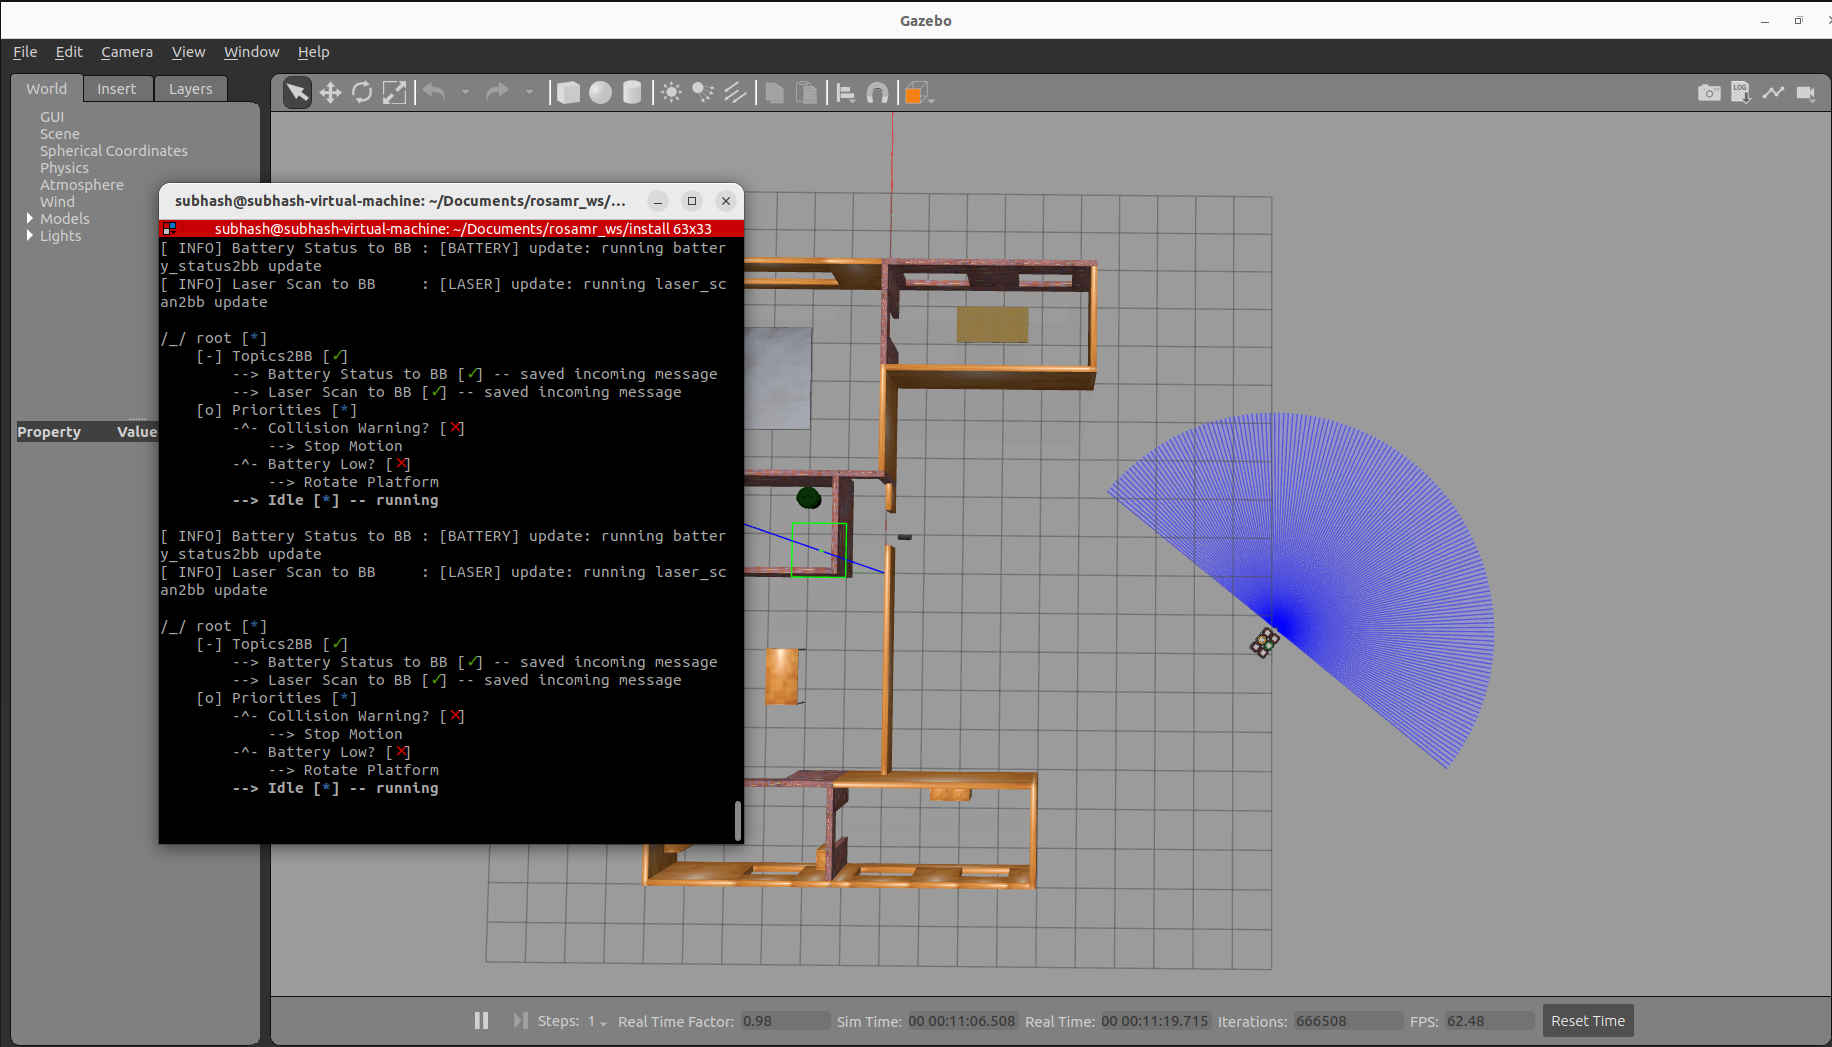

when collision detected
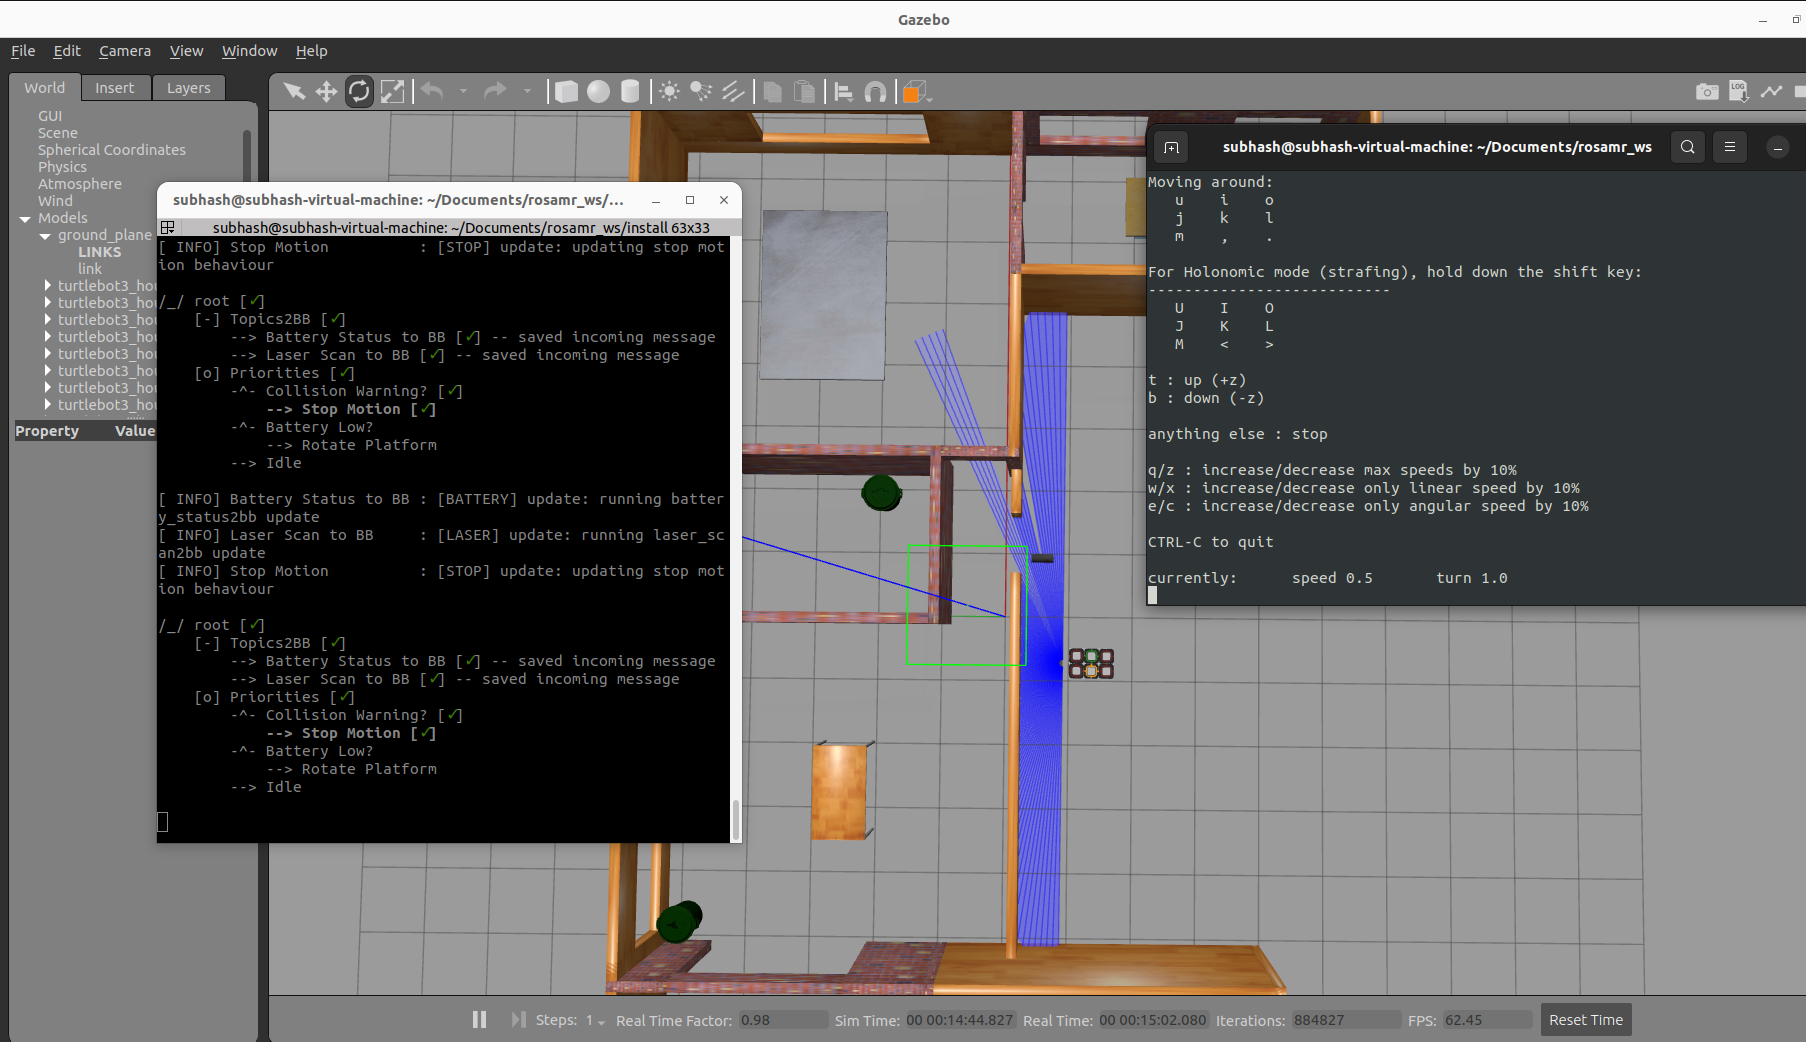